→ Plan of action:
1. Set numpy seed
2. Add noise to the metabolomics portion of the dataset
3. Run BMCA on noisy data
4. Extract/compute the elasticity and control coefficients
5. Compare these results with the noiseless values and the ground truth values


# Set up 

In [ ]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import cloudpickle
import gzip

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyB/all_data/')

# Perturbing enzymes

In [3]:
ant ='../../../models/antimony/TopologyB.ant'  
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.7241056990445864e-15

In [4]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

In [5]:
pt_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [6]:
data_file01 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_0.1.csv')
data_file02 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_0.2.csv')
data_file03 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_0.3.csv')
data_file04 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_0.4.csv')
data_file05 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_0.5.csv')

data_file15 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_1.5.csv')
data_file3 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_3.csv')
data_file5 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_5.csv')
data_file7 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_7.csv')
data_file100 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_10.csv')

data_files = [data_file01, data_file02, data_file03, data_file04, data_file05, data_file15, data_file3, data_file5, data_file7, data_file100]
intended_ens = [i[enzymes] / i[enzymes].loc[0] for i in data_files]


In [7]:
# adding noise to enzyme data
for data in data_files: 
    enzyme_noise = data[enzymes]
    data[enzymes] = enzyme_noise * np.random.uniform(0.75, 1.25, size=enzyme_noise.shape)

In [8]:
BMCA_obj01 = antemll.antemll(ant, data_file01, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj02 = antemll.antemll(ant, data_file02, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj03 = antemll.antemll(ant, data_file03, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj04 = antemll.antemll(ant, data_file04, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj05 = antemll.antemll(ant, data_file05, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')

BMCA_obj15 = antemll.antemll(ant, data_file15, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj3 = antemll.antemll(ant, data_file3, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj5 = antemll.antemll(ant, data_file5, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj7 = antemll.antemll(ant, data_file7, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj100 = antemll.antemll(ant, data_file100, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


In [9]:
def run_prior_predictive(BMCA_obj):
    ll = emll.LinLogLeastNorm(BMCA_obj.N, BMCA_obj.Ex.to_numpy(), BMCA_obj.Ey.to_numpy(), BMCA_obj.v_star, driver='gelsy')
    
    with pm.Model() as pymc_model:
        # Initialize elasticities
        # Ex and Ey have to be shape (rxns, mets)
        Ex_t = pm.Deterministic('Ex', emll.util.initialize_elasticity(BMCA_obj.Ex.to_numpy().T, 'Ex', b=0.05, sd=1, alpha=5))
        Ey_t = pm.Deterministic('Ey', emll.util.initialize_elasticity(BMCA_obj.Ey.to_numpy().T, 'Ey', b=0.05, sd=1, alpha=5))

        trace_prior = pm.sample_prior_predictive()

    return trace_prior

# Running ADVI

In [10]:
def run_ADVI(BMCA_obj, intended_en):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=intended_en, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI(random_seed=SEED)
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    with pymc_model:
        trace = approx.sample(draws=1000, random_seed=SEED)
        ppc_vi = pm.sample_posterior_predictive(trace)

    return trace, ppc_vi

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 5,044.4
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,708
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,126.1
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,653.7
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,929.4
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,402.8
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,437.5
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 4,900
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 8,264.6
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 13,155
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


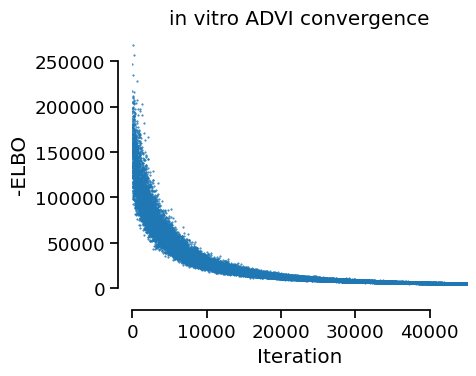

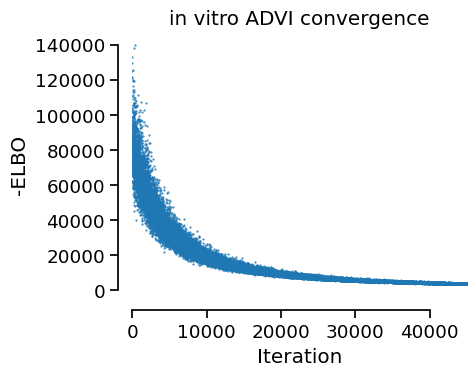

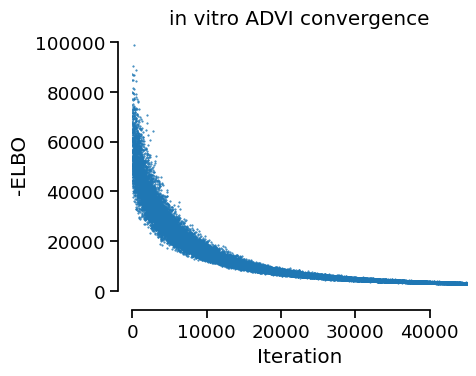

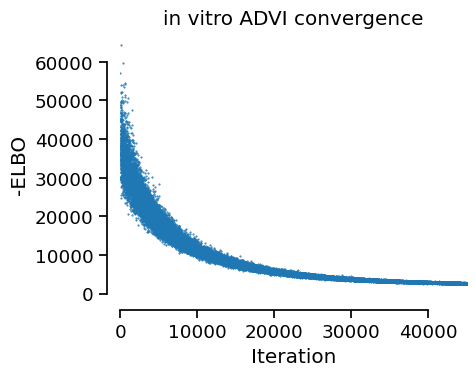

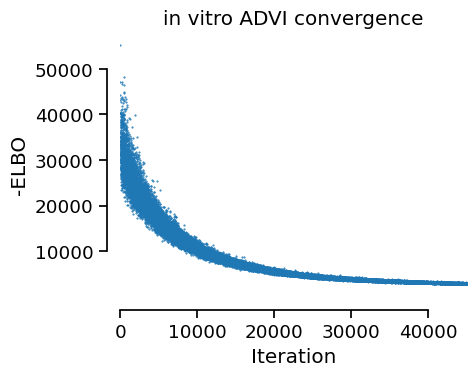

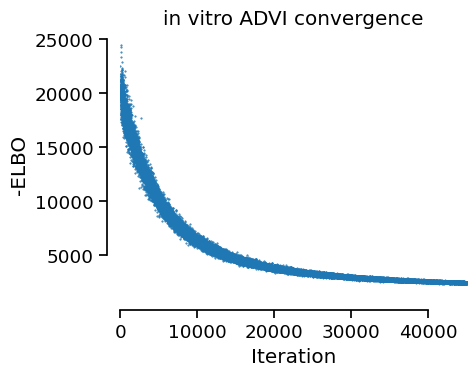

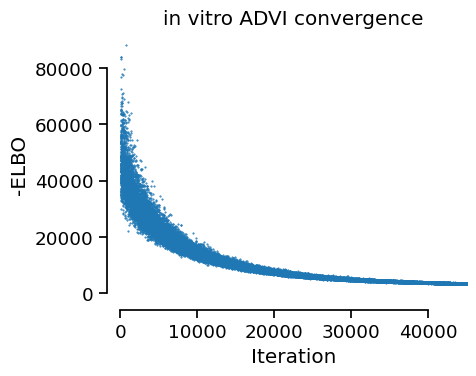

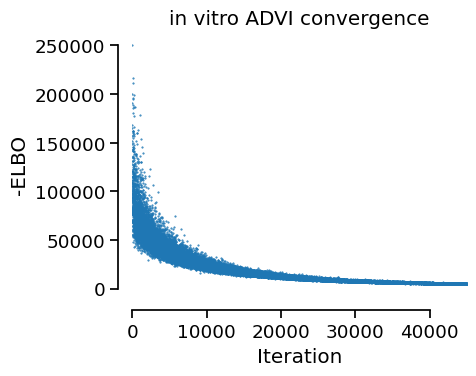

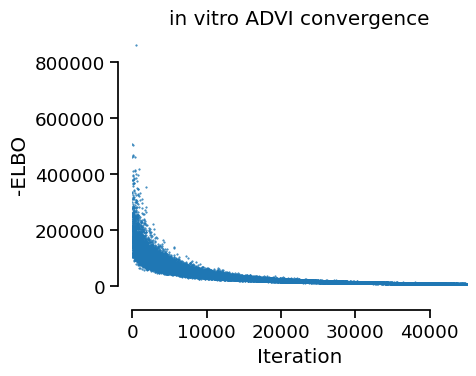

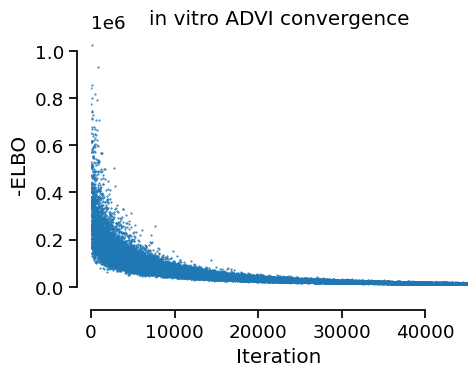

In [11]:
trace01, ppc01 = run_ADVI(BMCA_obj01, intended_ens[0].T)
trace02, ppc02 = run_ADVI(BMCA_obj02, intended_ens[1].T)
trace03, ppc03 = run_ADVI(BMCA_obj03, intended_ens[2].T)
trace04, ppc04 = run_ADVI(BMCA_obj04, intended_ens[3].T)
trace05, ppc05 = run_ADVI(BMCA_obj05, intended_ens[4].T)

trace15, ppc15 = run_ADVI(BMCA_obj15, intended_ens[5].T)
trace3, ppc3 = run_ADVI(BMCA_obj3, intended_ens[6].T)
trace5, ppc5 = run_ADVI(BMCA_obj5, intended_ens[7].T)
trace7, ppc7 = run_ADVI(BMCA_obj7, intended_ens[8].T)
trace100, ppc100 = run_ADVI(BMCA_obj100, intended_ens[9].T)

### saving trace data

In [12]:
with gzip.open("../../../data/results/tracePickles/echidna-topB_enzymes.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace01":trace01,
                "trace02":trace02,
                "trace03":trace03,
                "trace04":trace04,
                "trace05":trace05,
                "trace15":trace15,
                "trace3":trace3,
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100,
                "ppc01":ppc01,
                "ppc02":ppc02,
                "ppc03":ppc03,
                "ppc04":ppc04,
                "ppc05":ppc05,
                "ppc15":ppc15,
                "ppc3":ppc3,
                "ppc5":ppc5,
                "ppc7":ppc7,
                "ppc100":ppc100
                },
                f,
            )

# Analysis

In [13]:
with gzip.open('../../../data/results/tracePickles/echidna-topB_enzymes.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

noisytrace01=traces['trace01']
noisytrace02=traces['trace02']
noisytrace03=traces['trace03']
noisytrace04=traces['trace04']
noisytrace05=traces['trace05']
noisytrace15=traces['trace15']
noisytrace3=traces['trace3']
noisytrace5=traces['trace5']
noisytrace7=traces['trace7']
noisytrace100=traces['trace100']

noisy_traces = [noisytrace01, noisytrace02, noisytrace03, noisytrace04,
                noisytrace05,
                noisytrace15,
                noisytrace3,
                noisytrace5,
                noisytrace7,
                noisytrace100]

In [14]:
with gzip.open('../../../data/results/tracePickles/TopologyB-noReg_allData_traces.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

trace01=traces['trace01']
trace02=traces['trace02']
trace03=traces['trace03']
trace04=traces['trace04']
trace05=traces['trace05']
trace15=traces['trace15']
trace3=traces['trace3']
trace5=traces['trace5']
trace7=traces['trace7']
trace100=traces['trace100']

traces = [trace01, trace02, trace03, trace04,
                trace05,
                trace15,
                trace3,
                trace5,
                trace7,
                trace100]


### Elasticity check 

In [15]:
noisy_elasticities = [util.get_az_summary(i) for i in noisy_traces]
elasticities = [util.get_az_summary(i) for i in traces]

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [16]:
noisy_elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten()] + noisy_elasticities)

noisy_elasticities_df = pd.DataFrame(noisy_elasticity_values, columns=['gt']+pt_labels,
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
noisy_elasticities_df.head()

,gt,0.1x,0.2x,0.3x,0.4x,0.5x,1.5x,3x,5x,7x,10x
v1_D,0.000000,0.041,0.005,-0.007,0.021,0.004,0.000,0.012,0.007,0.009,-0.005
v1_B,-0.278258,-0.047,-0.299,-0.103,-0.208,-0.161,-0.407,-0.419,-0.481,-0.410,-0.413
v1_O,0.000000,-0.011,0.002,0.007,0.003,0.012,0.001,-0.003,0.003,0.035,-0.050
v1_F,0.000000,0.009,-0.013,-0.009,0.017,0.016,0.007,0.003,0.021,-0.003,-0.001
v1_H,0.000000,0.016,0.014,-0.003,-0.011,0.007,0.002,-0.001,0.010,-0.005,-0.011


In [17]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten()] + elasticities)

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels,
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
elasticities_df.head()

,gt,0.1x,0.2x,0.3x,0.4x,0.5x,1.5x,3x,5x,7x,10x
v1_D,0.000000,0.012,0.006,0.010,0.003,-0.005,-0.003,0.009,-0.008,0.005,0.004
v1_B,-0.278258,-0.338,-0.306,-0.239,-0.232,-0.208,-0.336,-0.403,-0.436,-0.437,-0.442
v1_O,0.000000,-0.015,0.005,0.008,0.000,0.004,0.001,-0.002,0.006,0.009,-0.004
v1_F,0.000000,0.006,-0.004,0.010,-0.003,0.007,0.004,0.008,-0.001,0.004,0.005
v1_H,0.000000,0.008,0.010,0.006,-0.003,0.006,-0.001,0.003,0.000,0.006,0.000


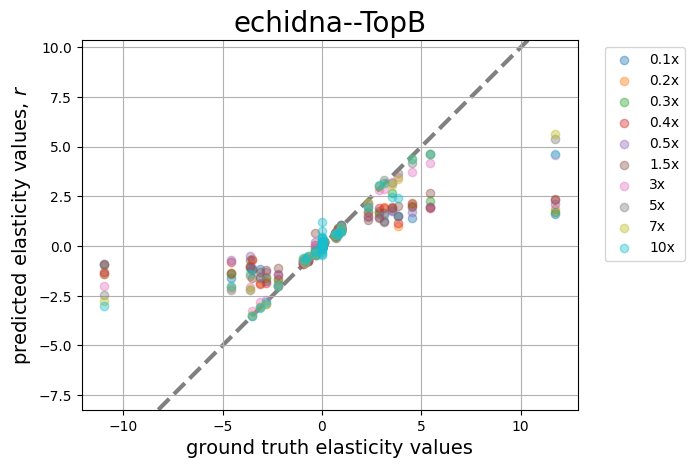

In [18]:
plt.axes().set_aspect('equal', 'datalim')
for i in elasticities_df.drop('gt', axis=1).columns:
    plt.scatter(elasticities_df['gt'], elasticities_df[i], alpha=0.4, label=i, zorder=10)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('echidna--TopB', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


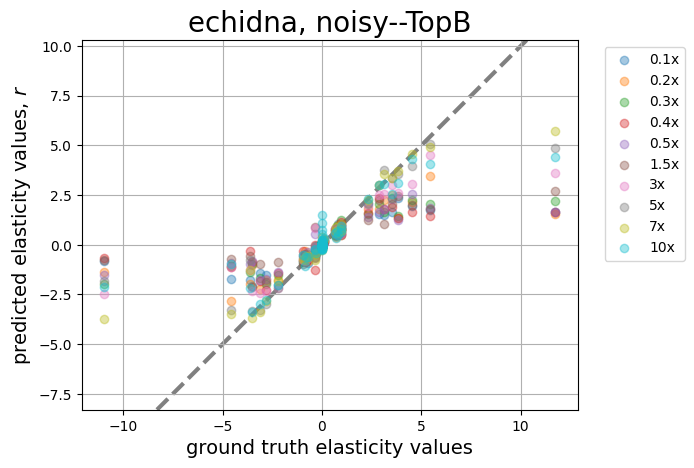

In [19]:
plt.axes().set_aspect('equal', 'datalim')
for i in noisy_elasticities_df.drop('gt', axis=1).columns:
    plt.scatter(noisy_elasticities_df['gt'], noisy_elasticities_df[i], alpha=0.4, label=i, zorder=10)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('echidna, noisy--TopB', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


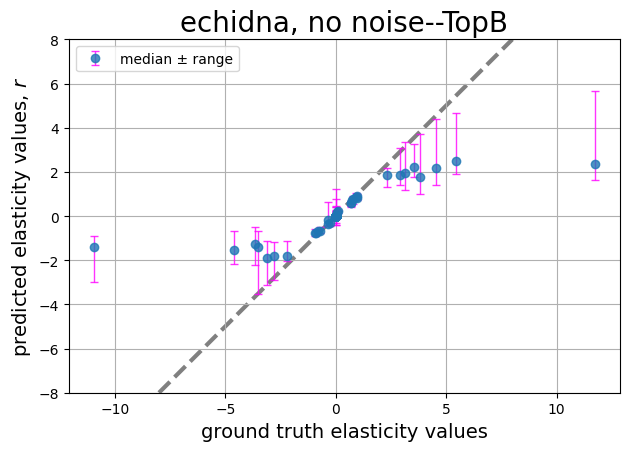

In [20]:
# Extract relevant data
preds_only = elasticities_df.drop('gt', axis=1)
gt_values = elasticities_df['gt']
medians = preds_only.median(axis=1)
mins = preds_only.min(axis=1)
maxs = preds_only.max(axis=1)

# Calculate error bars (asymmetric)
lower_err = medians - mins
upper_err = maxs - medians
asymmetric_error = [lower_err, upper_err]

# Plot
fig, ax = plt.subplots()
ax.set_aspect('equal')

# Plot medians with error bars
ax.errorbar(
    gt_values,
    medians,
    yerr=asymmetric_error,
    fmt='o',
    ecolor='magenta',
    alpha=0.8,
    elinewidth=1,
    capsize=3,
    label='median ± range',
    zorder=10
)

# Reference line
ax.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax.set_ylim(-8,8)
# Style
ax.grid(True, which='both', axis='both', zorder=0)
ax.set_xlabel('ground truth elasticity values', size=14)
ax.set_ylabel('predicted elasticity values, $\it{r}$', size=14)
ax.set_title('echidna, no noise--TopB', size=20)
ax.legend() #bbox_to_anchor=(1.04, 1), loc="upper left")

plt.tight_layout()
plt.show()


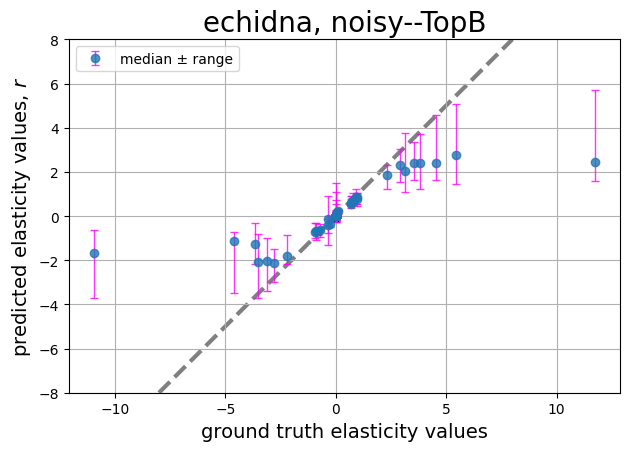

In [21]:
# Extract relevant data
preds_only = noisy_elasticities_df.drop('gt', axis=1)
gt_values = noisy_elasticities_df['gt']
medians = preds_only.median(axis=1)
mins = preds_only.min(axis=1)
maxs = preds_only.max(axis=1)

# Calculate error bars (asymmetric)
lower_err = medians - mins
upper_err = maxs - medians
asymmetric_error = [lower_err, upper_err]

# Plot
fig, ax = plt.subplots()
plt.gca().set_aspect('equal')

# Plot medians with error bars
plt.errorbar(
    gt_values,
    medians,
    yerr=asymmetric_error,
    fmt='o',
    ecolor='magenta',
    alpha=0.8,
    elinewidth=1,
    capsize=3,
    label='median ± range',
    zorder=10
)

# Reference line
ax.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)

ax.set_ylim(-8,8)

# Style
ax.grid(True, which='both', axis='both', zorder=0)
ax.set_xlabel('ground truth elasticity values', size=14)
ax.set_ylabel('predicted elasticity values, $\it{r}$', size=14)
ax.set_title('echidna, noisy--TopB', size=20)
ax.legend() #bbox_to_anchor=(1.04, 1), loc="upper left")

plt.tight_layout()
plt.show()


## Calculating CCC values and making graphs

In [22]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())

### posteriors

In [23]:
# all data
postCCC01 = util.estimate_CCCs(BMCA_obj01, elasticities[0].reshape((19, -1)))
postCCC02 = util.estimate_CCCs(BMCA_obj02, elasticities[1].reshape((19, -1)))
postCCC03 = util.estimate_CCCs(BMCA_obj03, elasticities[2].reshape((19, -1)))
postCCC04 = util.estimate_CCCs(BMCA_obj04, elasticities[3].reshape((19, -1)))
postCCC05 = util.estimate_CCCs(BMCA_obj05, elasticities[4].reshape((19, -1)))
postCCC15 = util.estimate_CCCs(BMCA_obj15, elasticities[5].reshape((19, -1)))
postCCC3 = util.estimate_CCCs(BMCA_obj3, elasticities[6].reshape((19, -1)))
postCCC5 = util.estimate_CCCs(BMCA_obj5, elasticities[7].reshape((19, -1)))
postCCC7 = util.estimate_CCCs(BMCA_obj7, elasticities[8].reshape((19, -1)))
postCCC100 = util.estimate_CCCs(BMCA_obj100, elasticities[9].reshape((19, -1)))

postCCCs = [postCCC01, postCCC02, postCCC03, postCCC04, postCCC05, postCCC15, postCCC3, postCCC5, postCCC7, postCCC100]

postCCC_meds = [-pd.DataFrame(np.median(postCCC, axis=0), columns=r.getReactionIds(), index=r.getFloatingSpeciesIds()) for postCCC in postCCCs]
postCCC_meds = pd.concat([i.melt()['value'] for i in postCCC_meds], axis=1).values
postCCC_meds = pd.DataFrame(postCCC_meds, columns=pt_labels)
postCCC_meds['median'] = postCCC_meds.median(axis=1)
postCCC_meds['min'] = postCCC_meds.min(axis=1)
postCCC_meds['max'] = postCCC_meds.max(axis=1)

CCC_lower_y_post = np.array(postCCC_meds['median']) - np.array(postCCC_meds['min'])
CCC_upper_y_post = np.array(postCCC_meds['max']) - np.array(postCCC_meds['median'])
CCC_errors_post = [CCC_lower_y_post, CCC_upper_y_post]

In [24]:
# all data
noisy_postCCC01 = util.estimate_CCCs(BMCA_obj01, noisy_elasticities[0].reshape((19, -1)))
noisy_postCCC02 = util.estimate_CCCs(BMCA_obj02, noisy_elasticities[1].reshape((19, -1)))
noisy_postCCC03 = util.estimate_CCCs(BMCA_obj03, noisy_elasticities[2].reshape((19, -1)))
noisy_postCCC04 = util.estimate_CCCs(BMCA_obj04, noisy_elasticities[3].reshape((19, -1)))
noisy_postCCC05 = util.estimate_CCCs(BMCA_obj05, noisy_elasticities[4].reshape((19, -1)))
noisy_postCCC15 = util.estimate_CCCs(BMCA_obj15, noisy_elasticities[5].reshape((19, -1)))
noisy_postCCC3 = util.estimate_CCCs(BMCA_obj3, noisy_elasticities[6].reshape((19, -1)))
noisy_postCCC5 = util.estimate_CCCs(BMCA_obj5, noisy_elasticities[7].reshape((19, -1)))
noisy_postCCC7 = util.estimate_CCCs(BMCA_obj7, noisy_elasticities[8].reshape((19, -1)))
noisy_postCCC100 = util.estimate_CCCs(BMCA_obj100, noisy_elasticities[9].reshape((19, -1)))

noisy_postCCCs = [noisy_postCCC01, noisy_postCCC02, noisy_postCCC03, noisy_postCCC04, noisy_postCCC05, noisy_postCCC15, noisy_postCCC3, noisy_postCCC5, noisy_postCCC7, noisy_postCCC100]

noisy_postCCC_meds = [-pd.DataFrame(np.median(noisy_postCCC, axis=0), columns=r.getReactionIds(), index=r.getFloatingSpeciesIds()) for noisy_postCCC in noisy_postCCCs]
noisy_postCCC_meds = pd.concat([i.melt()['value'] for i in noisy_postCCC_meds], axis=1).values
noisy_postCCC_meds = pd.DataFrame(noisy_postCCC_meds, columns=pt_labels)
noisy_postCCC_meds['median'] = noisy_postCCC_meds.median(axis=1)
noisy_postCCC_meds['min'] = noisy_postCCC_meds.min(axis=1)
noisy_postCCC_meds['max'] = noisy_postCCC_meds.max(axis=1)

noisy_CCC_lower_y_post = np.array(noisy_postCCC_meds['median']) - np.array(noisy_postCCC_meds['min'])
noisy_CCC_upper_y_post = np.array(noisy_postCCC_meds['max']) - np.array(noisy_postCCC_meds['median'])
noisy_CCC_errors_post = [noisy_CCC_lower_y_post, noisy_CCC_upper_y_post]

### CCC graphs

In [25]:
from sklearn.metrics import r2_score

# Flatten ground truth values
gt_values = gtCCC.melt()['value'].values

# Compute R-squared
r2_no_noise = r2_score(gt_values, postCCC_meds['median'].values)
r2_noise = r2_score(gt_values, noisy_postCCC_meds['median'].values)

print(f"R² (no noise): {r2_no_noise:.3f}")
print(f"R² (with noise): {r2_noise:.3f}")


R² (no noise): 0.954
R² (with noise): 0.960


Text(0.05, 0.71, '$R^2$ (w/ noise) = 0.96')

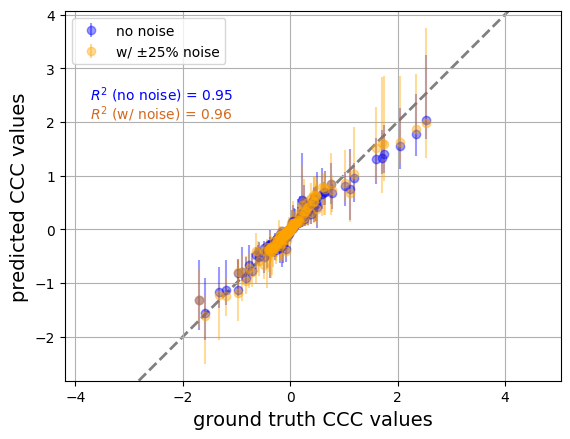

In [26]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtCCC.melt()['value'], postCCC_meds['median'], yerr=CCC_errors_post, alpha=0.4, fmt='o', label='no noise', zorder=100, c='b')
plt.errorbar(gtCCC.melt()['value'], noisy_postCCC_meds['median'], yerr=noisy_CCC_errors_post, alpha=0.4, fmt='o', label='w/ ±25% noise', zorder=100, c='orange')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth CCC values', size=14)
plt.ylabel('predicted CCC values', size=14)

plt.text(0.05, 0.76, f'$R^2$ (no noise) = {r2_no_noise:.2f}', transform=plt.gca().transAxes, color='b')
plt.text(0.05, 0.71, f'$R^2$ (w/ noise) = {r2_noise:.2f}', transform=plt.gca().transAxes, color='chocolate')

# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianCCCs.svg', format="svg")

Text(0.05, 0.7, '$R^2$ (w/ noise) = 0.96')

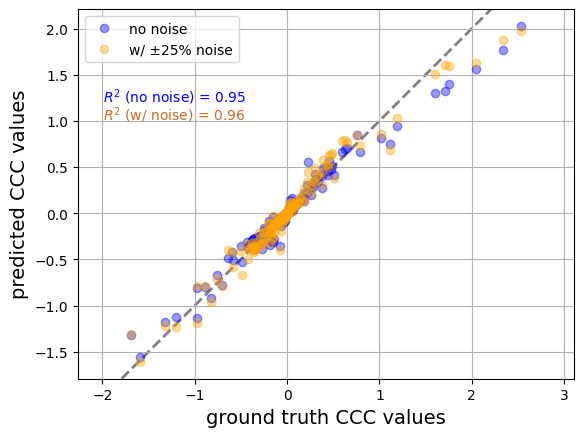

In [27]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtCCC.melt()['value'], postCCC_meds['median'], alpha=0.4, fmt='o', label='no noise', zorder=100, c='b')
plt.errorbar(gtCCC.melt()['value'], noisy_postCCC_meds['median'], alpha=0.4, fmt='o', label='w/ ±25% noise', zorder=100, c='orange')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth CCC values', size=14)
plt.ylabel('predicted CCC values', size=14)

plt.text(0.05, 0.75, f'$R^2$ (no noise) = {r2_no_noise:.2f}', transform=plt.gca().transAxes, color='b')
plt.text(0.05, 0.70, f'$R^2$ (w/ noise) = {r2_noise:.2f}', transform=plt.gca().transAxes, color='chocolate')

# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianCCCs.svg', format="svg")

## Calculating FCCs

In [28]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [29]:
postFCC01 = util.estimate_FCCs(BMCA_obj01, elasticities[0].reshape((19, -1)))
postFCC02 = util.estimate_FCCs(BMCA_obj02, elasticities[1].reshape((19, -1)))
postFCC03 = util.estimate_FCCs(BMCA_obj03, elasticities[2].reshape((19, -1)))
postFCC04 = util.estimate_FCCs(BMCA_obj04, elasticities[3].reshape((19, -1)))
postFCC05 = util.estimate_FCCs(BMCA_obj05, elasticities[4].reshape((19, -1)))
postFCC15 = util.estimate_FCCs(BMCA_obj15, elasticities[5].reshape((19, -1)))
postFCC3 = util.estimate_FCCs(BMCA_obj3, elasticities[6].reshape((19, -1)))
postFCC5 = util.estimate_FCCs(BMCA_obj5, elasticities[7].reshape((19, -1)))
postFCC7 = util.estimate_FCCs(BMCA_obj7, elasticities[8].reshape((19, -1)))
postFCC100 = util.estimate_FCCs(BMCA_obj100, elasticities[9].reshape((19, -1)))

post_FCCs = [postFCC01, postFCC02, postFCC03, postFCC04, postFCC05, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]

postFCC_meds = [-pd.DataFrame(np.median(postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()) for postFCC in post_FCCs]
postFCC_meds = pd.concat([i.melt()['value'] for i in postFCC_meds], axis=1).values
postFCC_meds = pd.DataFrame(postFCC_meds, columns=pt_labels)
postFCC_meds['median'] = postFCC_meds.median(axis=1)
postFCC_meds['min'] = postFCC_meds.min(axis=1)
postFCC_meds['max'] = postFCC_meds.max(axis=1)
# postFCC_meds

FCC_lower_y_post = np.array(postFCC_meds['median']) - np.array(postFCC_meds['min'])
FCC_upper_y_post = np.array(postFCC_meds['max']) - np.array(postFCC_meds['median'])
FCC_errors_post = [FCC_lower_y_post, FCC_upper_y_post]

In [30]:
noisy_postFCC01 = util.estimate_FCCs(BMCA_obj01, noisy_elasticities[0].reshape((19, -1)))
noisy_postFCC02 = util.estimate_FCCs(BMCA_obj02, noisy_elasticities[1].reshape((19, -1)))
noisy_postFCC03 = util.estimate_FCCs(BMCA_obj03, noisy_elasticities[2].reshape((19, -1)))
noisy_postFCC04 = util.estimate_FCCs(BMCA_obj04, noisy_elasticities[3].reshape((19, -1)))
noisy_postFCC05 = util.estimate_FCCs(BMCA_obj05, noisy_elasticities[4].reshape((19, -1)))
noisy_postFCC15 = util.estimate_FCCs(BMCA_obj15, noisy_elasticities[5].reshape((19, -1)))
noisy_postFCC3 = util.estimate_FCCs(BMCA_obj3, noisy_elasticities[6].reshape((19, -1)))
noisy_postFCC5 = util.estimate_FCCs(BMCA_obj5, noisy_elasticities[7].reshape((19, -1)))
noisy_postFCC7 = util.estimate_FCCs(BMCA_obj7, noisy_elasticities[8].reshape((19, -1)))
noisy_postFCC100 = util.estimate_FCCs(BMCA_obj100, noisy_elasticities[9].reshape((19, -1)))

noisy_post_FCCs = [noisy_postFCC01, noisy_postFCC02, noisy_postFCC03, noisy_postFCC04, noisy_postFCC05, noisy_postFCC15, noisy_postFCC3, noisy_postFCC5, noisy_postFCC7, noisy_postFCC100]

noisy_postFCC_meds = [-pd.DataFrame(np.median(noisy_postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()) for noisy_postFCC in noisy_post_FCCs]
noisy_postFCC_meds = pd.concat([i.melt()['value'] for i in noisy_postFCC_meds], axis=1).values
noisy_postFCC_meds = pd.DataFrame(noisy_postFCC_meds, columns=pt_labels)
noisy_postFCC_meds['median'] = noisy_postFCC_meds.median(axis=1)
noisy_postFCC_meds['min'] = noisy_postFCC_meds.min(axis=1)
noisy_postFCC_meds['max'] = noisy_postFCC_meds.max(axis=1)
# noisy_postFCC_meds

noisy_FCC_lower_y_post = np.array(noisy_postFCC_meds['median']) - np.array(noisy_postFCC_meds['min'])
noisy_FCC_upper_y_post = np.array(noisy_postFCC_meds['max']) - np.array(noisy_postFCC_meds['median'])
noisy_FCC_errors_post = [noisy_FCC_lower_y_post, noisy_FCC_upper_y_post]

## FCC graphs

In [31]:
## adding corrections 
rxn = np.repeat(r.getReactionIds(),len(r.getReactionIds()))
enz_pt = r.getReactionIds() * len(r.getReactionIds())
FCC_idx = pd.DataFrame([rxn, enz_pt]).T

pt_enz_is_rxn = np.linspace(0,len(rxn)-1,len(r.getReactionIds()))
pt_enz_is_rxn

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.,
       220., 240., 260., 280., 300., 320., 340., 360.])

In [32]:
postFCC_meds.loc[pt_enz_is_rxn, 'median'] += 2
noisy_postFCC_meds.loc[pt_enz_is_rxn, 'median'] += 2

In [33]:
from sklearn.metrics import r2_score

# Flatten ground truth values
gt_values = gtFCC.melt()['value'].values

# Compute R-squared
r2_no_noise = r2_score(gt_values, postFCC_meds['median'].values)
r2_noise = r2_score(gt_values, noisy_postFCC_meds['median'].values)

print(f"R² (no noise): {r2_no_noise:.3f}")
print(f"R² (with noise): {r2_noise:.3f}")


R² (no noise): 0.951
R² (with noise): 0.943


Text(0.05, 0.75, '$R^2$ (w/ noise) = 0.94')

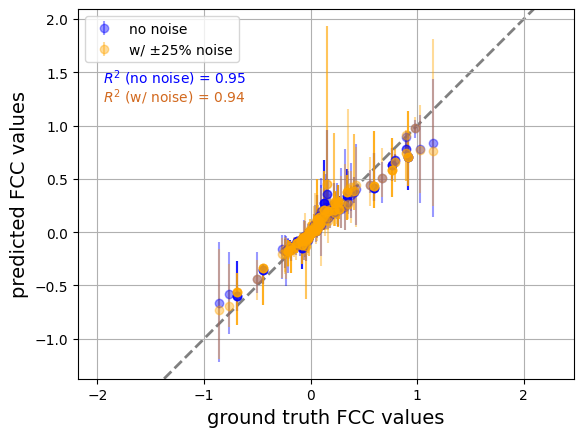

In [34]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], postFCC_meds['median'], yerr=FCC_errors_post, alpha=0.4, fmt='o', label='no noise', zorder=100, c='b')
plt.errorbar(gtFCC.melt()['value'], noisy_postFCC_meds['median'], yerr=noisy_FCC_errors_post, alpha=0.4, fmt='o', label='w/ ±25% noise', zorder=100, c='orange')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)

plt.text(0.05, 0.80, f'$R^2$ (no noise) = {r2_no_noise:.2f}', transform=plt.gca().transAxes, color='b')
plt.text(0.05, 0.75, f'$R^2$ (w/ noise) = {r2_noise:.2f}', transform=plt.gca().transAxes, color='chocolate')

# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_wCorrection.svg', format="svg")

Text(0.05, 0.7, '$R^2$ (w/ noise) = 0.94')

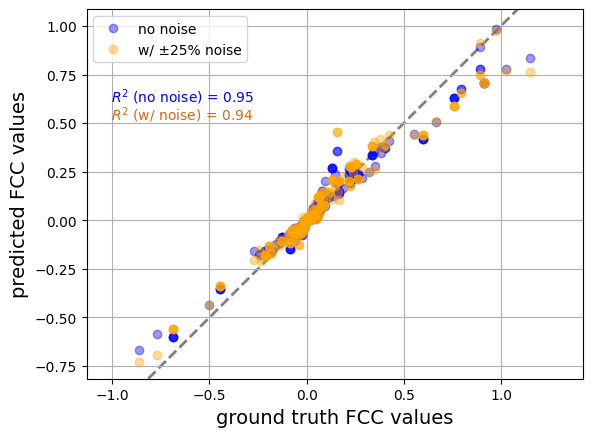

In [35]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], postFCC_meds['median'], alpha=0.4, fmt='o', label='no noise', zorder=100, c='b')
plt.errorbar(gtFCC.melt()['value'], noisy_postFCC_meds['median'], alpha=0.4, fmt='o', label='w/ ±25% noise', zorder=100, c='orange')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)

plt.text(0.05, 0.75, f'$R^2$ (no noise) = {r2_no_noise:.2f}', transform=plt.gca().transAxes, color='b')
plt.text(0.05, 0.70, f'$R^2$ (w/ noise) = {r2_noise:.2f}', transform=plt.gca().transAxes, color='chocolate')

# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_wCorrection.svg', format="svg")